<h1> I. Beginning </h1>

In [69]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search

pd.options.display.max_rows = 100

In [70]:
# Feature Importance
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

## Import Data

In [71]:
train = pd.read_csv('./data/train.csv', sep = ",", nrows = 1000000)
test = pd.read_csv('./data/test.csv', sep = ",", nrows = 1000000)

In [72]:
IDtest = test['sample_id']
test.drop('sample_id',inplace=True,axis=1)

In [73]:
test.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age
0,50,1478104371,683078,82356,1,20021008,0,0,542,1,0,17698,2076,30
1,2744,1479317140,876497,99692,1,19851231,0,0,307,1,0,10525,26,28
2,2744,1479546361,876497,99692,1,19851231,0,0,307,1,0,8716,26,27
3,2744,1478457729,876500,99692,1,19851231,2,1,265,1,0,5443,26,30
4,2744,1480448560,876504,99692,1,19851231,2,1,356,1,0,7600,26,29


In [74]:
train.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


### Take out absurd data

In [75]:
train.drop(train.index[(train['media_duration'] <= 30)*(train['is_listened'] == 1)], axis = 0, inplace = True)

In [76]:
import time
import datetime
conv_date = lambda x: time.mktime(datetime.datetime.strptime(str(x), '%Y%m%d').timetuple())
train['release_date'] = train['release_date'].apply(conv_date)
test['release_date'] = test['release_date'].apply(conv_date)

In [77]:
train.drop(train.index[train['ts_listen'] > time.time()], axis = 0, inplace = True)
train.drop(train.index[train['ts_listen'] < 1477500000], axis = 0, inplace = True)
train.drop(train.index[train['release_date'] > time.time()], axis = 0, inplace = True)
# train.drop(train.index[train['ts_listen'] < train['release_date']], axis = 0, inplace = True) 28827 valeurs dans le train, 32 dans le test, presques toutes avec genre_id == 0

In [78]:
# not so bad anyways... - and none in the test
# len(train[train['ts_listen'] < 1230764491]) (= 631)

### Combined contains the common columns to the test and train set, in order to apply the same transformations on all the data

In [79]:
target = train['is_listened']
train.drop('is_listened', axis = 1, inplace = True)
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop('index', axis = 1, inplace = True)
train['is_listened'] = target

In [80]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age
0,25471,1480597215,222606,41774,12,1.088892e+09,1,0,223,0,0,9241,55164,29
1,25571,1480544735,250467,43941,0,1.141168e+09,2,1,171,0,0,16547,55830,30
2,16,1479563953,305197,48078,1,1.405289e+09,2,1,149,1,1,7665,2704,29
3,7,1480152098,900502,71521,0,9.728604e+08,0,0,240,0,1,1580,938,30
4,7,1478368974,542335,71718,0,1.203030e+09,0,0,150,0,1,1812,2939,24


In [81]:
# Took the data from "input.csv"

# How to process it?

# Genre_id, media_id, album_id, user_id, artist_id -> aggregate (e.g. count)
# Ts_listen, release_date: date under 2 different formats -> put to same format
# Context_type -> one-hot-encode
# Platform_name, platform_family -> one-hot encode? Aggregate?
# Media_duration -> this one seems simple, keep as is
# Listen_type -> probably keep as is, but not sure
# User_gender -> keep as is (sexism!)
# User_age -> keep as is

# Other ideas: compute mean length for an album, an artist, a genre, mean of is_listened for each user, each artist, etc using the date 
# Using the date, we can compute the number of songs he listened in a row

# I think the key here is correctly using the information about artist, etc...


<h1> II. Feature Preparation </h1>

In [82]:
# def medianNan(s):
#     global combined
#     combined[s].fillna(np.median(combined[~np.isnan(combined[s])][s]), inplace=True)

### Filling NaN values with the median of the column

In [83]:
# for s in combined.columns[1:]:
# #     print(s,type(combined[s][0]))
#     medianNan(s)

### Dealing with categoricals

In [84]:
categorical = ['platform_name', 'platform_family'] ## 'context_type' TOO BIG! (MemoryError)

In [85]:
def dummify(variable):
    global combined
    local_dummies = pd.get_dummies(combined[variable],prefix=variable)
    combined = pd.concat([combined,local_dummies],axis=1)
    combined.drop(variable,axis=1,inplace=True)

In [86]:
for s in categorical:
    dummify(s)

## DATA VISUALISATION

### Same user ID's in test and train

In [87]:
sorted(train['user_id'].unique()) == sorted(test['user_id'].unique())

False

### listen_type == 1 in test set (apart from one value)

In [88]:
sorted(test['listen_type'])[1]

1

<h1> III. Feature Engineering </h1>

## Genre_id, media_id, album_id, user_id, artist_id -> aggregate (e.g. count)

In [89]:
def aggregation_functions(name):
    
    global combined
    global train
    
    avrg = train.groupby([name + '_id'])['is_listened'].mean()
    avrg_flow = train[train['listen_type'] == 1].groupby([name + '_id'])['is_listened'].mean()
    avrg_noflow = train[train['listen_type'] == 0].groupby([name + '_id'])['is_listened'].mean()

    avrg.name = 'avrg_listened_' + name
    avrg_flow.name = 'avrg_listened_' + name + '_flow'
    avrg_noflow.name = 'avrg_listened_' + name + '_noflow'

    combined = combined.join(avrg, name + '_id', 'left')
    combined = combined.join(avrg_flow, name + '_id', 'left')
    combined = combined.join(avrg_noflow, name + '_id', 'left')

    combined['avrg_listened_' + name].fillna(np.median(combined[~np.isnan(combined['avrg_listened_' + name])]['avrg_listened_' + name]), inplace=True)
    
    combined['avrg_listened_' + name + '_flow'].fillna(combined['avrg_listened_' + name], inplace=True)
    combined['avrg_listened_' + name + '_noflow'].fillna(combined['avrg_listened_' + name], inplace=True)

    combined['avrg_listened_' + name + '_current'] = combined['avrg_listened_' + name + '_flow']*combined['listen_type'] + combined['avrg_listened_' + name + '_noflow']*(1-combined['listen_type'])

    count_ = combined.groupby([name + '_id'])[name + '_id'].count()
    count_.name = 'count_' + name
    combined = combined.join(count_, name + '_id', 'left')

### Mean of is_listened by ___ on flow or not

In [90]:
aggregation_functions('user')
aggregation_functions('artist')
aggregation_functions('media')
aggregation_functions('album')
aggregation_functions('genre')

### Compute age of song at the moment of listening (still some weird things on very few points...)

In [91]:
combined['age_song'] = combined['ts_listen'] - combined['release_date']

In [92]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,media_duration,listen_type,user_gender,user_id,artist_id,user_age,platform_name_0,platform_name_1,platform_name_2,platform_family_0,platform_family_1,platform_family_2,avrg_listened_user,avrg_listened_user_flow,avrg_listened_user_noflow,avrg_listened_user_current,count_user,avrg_listened_artist,avrg_listened_artist_flow,avrg_listened_artist_noflow,avrg_listened_artist_current,count_artist,avrg_listened_media,avrg_listened_media_flow,avrg_listened_media_noflow,avrg_listened_media_current,count_media,avrg_listened_album,avrg_listened_album_flow,avrg_listened_album_noflow,avrg_listened_album_current,count_album,avrg_listened_genre,avrg_listened_genre_flow,avrg_listened_genre_noflow,avrg_listened_genre_current,count_genre,age_song
0,25471,1480597215,222606,41774,12,1.088892e+09,223,0,0,9241,55164,29,0.0,1.0,0.0,1.0,0.0,0.0,0.476190,0.750,0.307692,0.307692,22,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.0000,0.0000,1,0.000000,0.0,0.000000,0.000000,1,0.711538,0.596730,0.774146,0.774146,1085,391705215.0
1,25571,1480544735,250467,43941,0,1.141168e+09,171,0,0,16547,55830,30,0.0,0.0,1.0,0.0,1.0,0.0,1.000000,1.000,1.000000,1.000000,3,1.000000,1.000000,1.000000,1.000000,3,1.000000,1.000000,1.0000,1.0000,1,1.000000,1.0,1.000000,1.000000,1,0.629526,0.616071,0.635628,0.635628,362,339377135.0
2,16,1479563953,305197,48078,1,1.405289e+09,149,1,1,7665,2704,29,0.0,0.0,1.0,0.0,1.0,0.0,0.954545,1.000,0.933333,1.000000,23,0.444444,0.500000,0.428571,0.500000,9,1.000000,1.000000,1.0000,1.0000,1,1.000000,1.0,1.000000,1.000000,1,0.774917,0.641304,0.833732,0.641304,1212,74275153.0
3,7,1480152098,900502,71521,0,9.728604e+08,240,0,1,1580,938,30,1.0,0.0,0.0,1.0,0.0,0.0,0.608696,0.475,0.663265,0.663265,139,0.484848,0.484848,0.484848,0.484848,34,0.000000,0.000000,0.0000,0.0000,1,0.000000,0.0,0.000000,0.000000,1,0.649713,0.583686,0.700462,0.700462,99915,507291698.0
4,7,1478368974,542335,71718,0,1.203030e+09,150,0,1,1812,2939,24,1.0,0.0,0.0,1.0,0.0,0.0,0.942149,0.850,0.960396,0.960396,122,0.838710,0.800000,0.864865,0.864865,62,0.866667,0.785714,0.9375,0.9375,30,0.882353,0.8,0.947368,0.947368,34,0.649713,0.583686,0.700462,0.700462,99915,275338974.0


## Other ideas: compute mean length for an album, an artist, a genre, mean of is_listened for each user, each artist, etc using the date 

### Time since previous song (what to do with the first value?)

In [93]:
combined_sorted = combined[['ts_listen', 'user_id']].sort_values(['user_id', 'ts_listen'])

In [94]:
# ttnxt = -(combined_sorted - combined_sorted.shift(-1))
# ttnxt['ts_listen'].ix[ttnxt['user_id'] != 0] = np.nan
# ttnxt['ts_listen'].fillna(int(np.max(ttnxt[~np.isnan(ttnxt['ts_listen'])]['ts_listen'])), inplace=True)

In [95]:
ttprv = combined_sorted - combined_sorted.shift(1)
ttprv['ts_listen'].ix[ttprv['user_id'] != 0] = np.nan
ttprv['ts_listen'].fillna(int(np.max(ttprv[~np.isnan(ttprv['ts_listen'])]['ts_listen'])), inplace=True)

In [96]:
combined_sorted['time_to_prev'] = ttprv['ts_listen']
# combined_sorted['time_to_next'] = ttnxt['ts_listen']

In [97]:
combined_sorted.head()

,ts_listen,user_id,time_to_prev
681200,1477939775,0,2769804.0
358531,1477985063,0,45288.0
917596,1477986106,0,1043.0
766677,1477987567,0,1461.0
631570,1477988897,0,1330.0


## Compute the number of songs listened in a row

In [98]:
lintervals = [30, 60, 180, 300, 600, 1800, 3600, 12*3600, 24*3600]
for t in lintervals:    
    combined_sorted['just_after'] = (combined_sorted['time_to_prev'] < t)*(1-ttprv['user_id']).fillna(0) == 1

    combined_sorted['just_after2'] = combined_sorted['just_after'].cumsum()
    combined_sorted['just_after3'] = (1-combined_sorted['just_after'])*combined_sorted['just_after2'].shift(1)
    combined_sorted['just_after4'] = combined_sorted['just_after3'].cummax()
    combined_sorted['n_in_a_row_' + str(t)] = (combined_sorted['just_after2'] - combined_sorted['just_after4']).fillna(0)

combined_sorted.head()

,ts_listen,user_id,time_to_prev,just_after,just_after2,just_after3,just_after4,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400
681200,1477939775,0,2769804.0,False,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358531,1477985063,0,45288.0,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
917596,1477986106,0,1043.0,True,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
766677,1477987567,0,1461.0,True,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0
631570,1477988897,0,1330.0,True,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,4.0


In [99]:
combined = combined.join(combined_sorted[['time_to_prev'] + ['n_in_a_row_' + str(t) for t in lintervals]], None, 'left', 'l')
combined_sorted = None

In [100]:
combined.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,media_duration,listen_type,user_gender,user_id,artist_id,user_age,platform_name_0,platform_name_1,platform_name_2,platform_family_0,platform_family_1,platform_family_2,avrg_listened_user,avrg_listened_user_flow,avrg_listened_user_noflow,avrg_listened_user_current,count_user,avrg_listened_artist,avrg_listened_artist_flow,avrg_listened_artist_noflow,avrg_listened_artist_current,count_artist,avrg_listened_media,avrg_listened_media_flow,avrg_listened_media_noflow,avrg_listened_media_current,count_media,avrg_listened_album,avrg_listened_album_flow,avrg_listened_album_noflow,avrg_listened_album_current,count_album,avrg_listened_genre,avrg_listened_genre_flow,avrg_listened_genre_noflow,avrg_listened_genre_current,count_genre,age_song,time_to_prev,n_in_a_row_30,n_in_a_row_60,n_in_a_row_180,n_in_a_row_300,n_in_a_row_600,n_in_a_row_1800,n_in_a_row_3600,n_in_a_row_43200,n_in_a_row_86400
0,25471,1480597215,222606,41774,12,1.088892e+09,223,0,0,9241,55164,29,0.0,1.0,0.0,1.0,0.0,0.0,0.476190,0.750,0.307692,0.307692,22,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.0000,0.0000,1,0.000000,0.0,0.000000,0.000000,1,0.711538,0.596730,0.774146,0.774146,1085,391705215.0,12.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,7.0,17.0
1,25571,1480544735,250467,43941,0,1.141168e+09,171,0,0,16547,55830,30,0.0,0.0,1.0,0.0,1.0,0.0,1.000000,1.000,1.000000,1.000000,3,1.000000,1.000000,1.000000,1.000000,3,1.000000,1.000000,1.0000,1.0000,1,1.000000,1.0,1.000000,1.000000,1,0.629526,0.616071,0.635628,0.635628,362,339377135.0,2769804.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16,1479563953,305197,48078,1,1.405289e+09,149,1,1,7665,2704,29,0.0,0.0,1.0,0.0,1.0,0.0,0.954545,1.000,0.933333,1.000000,23,0.444444,0.500000,0.428571,0.500000,9,1.000000,1.000000,1.0000,1.0000,1,1.000000,1.0,1.000000,1.000000,1,0.774917,0.641304,0.833732,0.641304,1212,74275153.0,4866.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
3,7,1480152098,900502,71521,0,9.728604e+08,240,0,1,1580,938,30,1.0,0.0,0.0,1.0,0.0,0.0,0.608696,0.475,0.663265,0.663265,139,0.484848,0.484848,0.484848,0.484848,34,0.000000,0.000000,0.0000,0.0000,1,0.000000,0.0,0.000000,0.000000,1,0.649713,0.583686,0.700462,0.700462,99915,507291698.0,1962.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.0,32.0
4,7,1478368974,542335,71718,0,1.203030e+09,150,0,1,1812,2939,24,1.0,0.0,0.0,1.0,0.0,0.0,0.942149,0.850,0.960396,0.960396,122,0.838710,0.800000,0.864865,0.864865,62,0.866667,0.785714,0.9375,0.9375,30,0.882353,0.8,0.947368,0.947368,34,0.649713,0.583686,0.700462,0.700462,99915,275338974.0,26938.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,12.0


## Date and time

### Hourly average...

In [101]:
def create_column_date(combined):
    combined['date'] = pd.to_datetime(combined['ts_listen'],unit='s')
    return combined

combined = create_column_date(combined)

In [102]:
train['hour'] = combined[:len(train)]['date'].dt.hour
combined['hour'] = combined['date'].dt.hour
avg_is_listened_per_hour = train.groupby(['hour'])['is_listened'].mean()
avg_is_listened_per_hour.name = 'avg_per_hour'
combined = combined.join(avg_is_listened_per_hour, 'hour', 'left')

combined.drop('date',axis=1,inplace=True)

In [103]:
newtrain = combined[:len(target)]
newtrain['is_listened'] = train['is_listened']
newtest = combined[len(target):]

(0.0, 80)

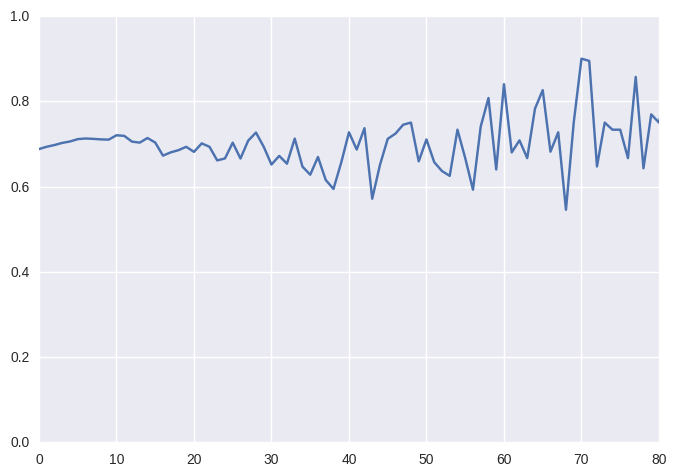

In [117]:
plt.plot(newtrain.groupby(['n_in_a_row_300'])['is_listened'].mean())
plt.xlim(xmax = 80)

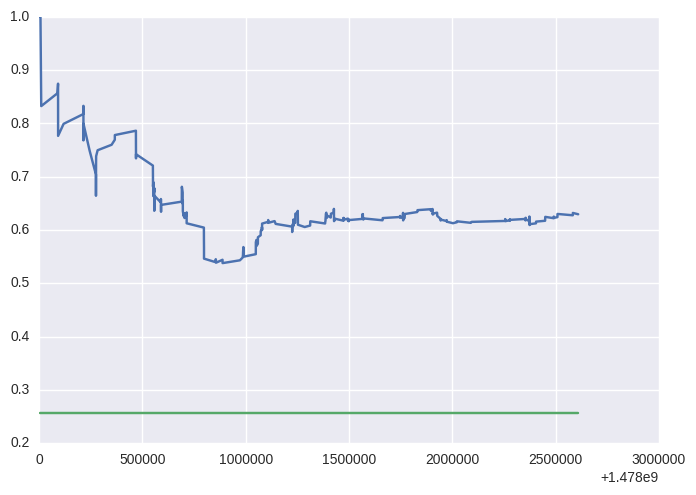

In [174]:
p = newtrain[newtrain['user_id'] == 150][['ts_listen', 'is_listened', 'avrg_listened_user']].sort_values(['ts_listen'])
plt.plot(p['ts_listen'], pd.ewma(p['is_listened'], span = 1000), '-')
plt.plot(p['ts_listen'], p['avrg_listened_user'], '-')

In [118]:
# chanson écoutée combien de fois, album, etc? a creuser

## CENTER DATA

In [7]:
combined.to_csv('temp_combined.csv', index=False)
target.to_csv('temp_target.csv', index=False)

In [10]:
combined = pd.read_csv('temp_combined.csv')
target = pd.read_csv('temp_target.csv', header = None)

In [6]:
for _ in combined.columns:
    if np.std(combined[_][:len(target)]) != 0:
        combined[_] = (combined[_] - np.mean(combined[_][:len(target)]))/np.std(combined[_][:len(target)])

<h1> IV. Modeling </h1>

## Separate the modified train and test sets

In [11]:
newtrain = combined[:len(target)]
newtest = combined[len(target):]

In [14]:
print(newtest['time_to_prev'].max())
print(newtest['time_to_prev'].min())
print(np.mean(newtest['time_to_prev']))
print(np.median(newtest['time_to_prev']))

248540550.0
1.0
85029.68475750578
4142.0


In [15]:
print(newtrain['time_to_prev'].max())
print(newtrain['time_to_prev'].min())
print(np.mean(newtrain['time_to_prev']))
print(np.median(newtrain['time_to_prev']))

248904905.0
1.0
659703.2117299706
187.0


## A function to visualize the importance of the features

In [15]:
sorted_idx = np.argsort(gbr.feature_importances_)

Index(['platform_name_2', 'platform_name_0', 'avrg_listened_media',
       'platform_name_1', 'avrg_listened_album_noflow',
       'avrg_listened_user_flow', 'count_album', 'avrg_listened_user',
       'avrg_listened_user_noflow', 'avrg_listened_artist_flow',
       'avrg_listened_genre_current', 'count_media',
       'avrg_listened_media_noflow', 'avrg_listened_artist_noflow',
       'platform_family_0', 'time_to_prev', 'avrg_listened_artist_current',
       'avrg_listened_media_current', 'context_type',
       'avrg_listened_user_current'],
      dtype='object')

In [8]:
def importanceVisualisation(feature_importance, predictors, firstN = 40):
    
    plt.rcParams["figure.figsize"] = [40,10]
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.bar(pos[-firstN:], feature_importance[sorted_idx][-firstN:], align='center')
    plt.xticks(pos[-firstN:], predictors[sorted_idx][-firstN:], rotation='vertical')
    plt.ylabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

<h1> IV - 1. Gradient Boosting </h1>

In [19]:
from sklearn import ensemble
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'huber', 'verbose':1}
gbr = ensemble.GradientBoostingRegressor(**params)

In [20]:
gbr.fit(newtrainLight, target)

      Iter       Train Loss   Remaining Time 
         1           0.1564          624.20m
         2           0.1548          511.87m
         3           0.1532          473.27m
         4           0.1517          453.87m
         5           0.1502          442.46m
         6           0.1487          433.91m
         7           0.1473          428.52m
         8           0.1459          424.35m
         9           0.1445          421.04m
        10           0.1431          418.24m
        20           0.1309          404.49m
        30           0.1208          394.43m
        40           0.1126          389.10m
        50           0.1057          384.77m
        60           0.1001          380.71m
        70           0.0954          374.82m
        80           0.0915          370.80m
        90           0.0883          366.89m
       100           0.0857          363.16m
       200           0.0748          323.45m
       300           0.0728          281.33m
       40

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=1, warm_start=False)

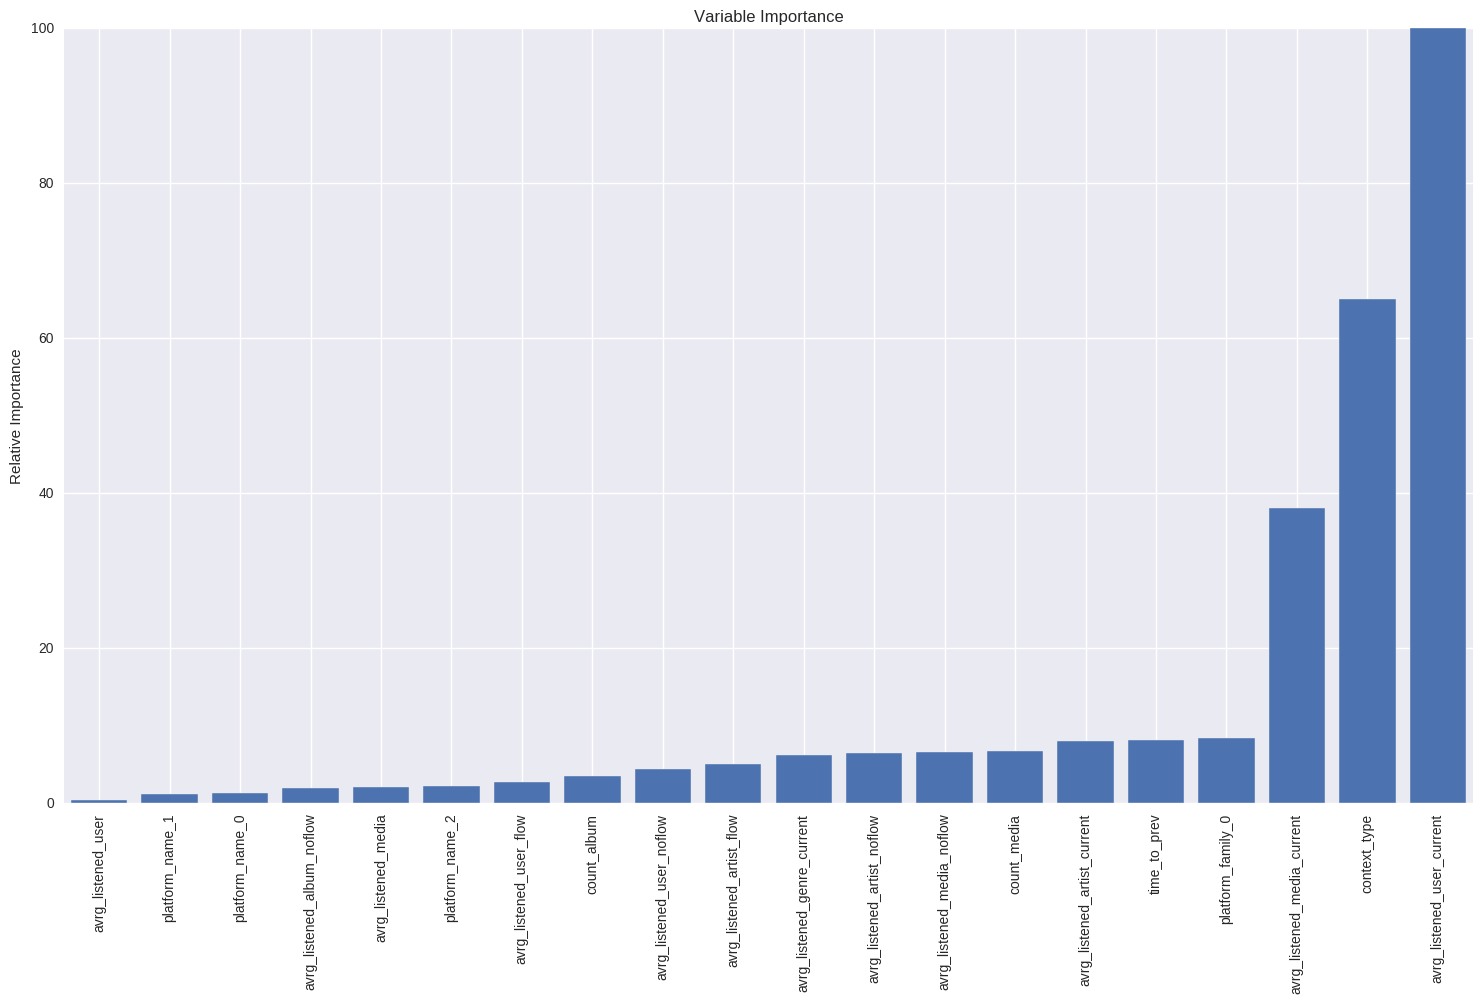

In [22]:
importanceVisualisation(gbr.feature_importances_, newtrainLight.columns)

<h1> IV - 2. XGBoost </h1>

In [6]:
from sklearn.model_selection import cross_val_predict

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50, plot = False):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], target, verbose_eval = True, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
    predicted_cv = cross_val_predict(alg, dtrain, target, cv = 5, n_jobs = -1)
    print('AUC Score (CV):',metrics.roc_auc_score(target, predicted_cv))
    
    if plot:
        importanceVisualisation(pd.Series(alg.booster().get_fscore()), predictors)

In [ ]:
predictors = newtrain.columns

## FIRST MODEL

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
#  nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, newtrain, predictors)

## GRID SEARCH ON XGBOOST TO FIND THE BEST PARAMETERS (VERY LONG)

## Grid search on 'max_depth' and 'min_child_weight'

In [ ]:
# param_test1 = {
#  'max_depth':np.array(range(3,10,2)),
#  'min_child_weight':np.array(range(1,6,2))
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch1.fit(newtrain[predictors],target)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

## Finer grid search on 'max_depth' and 'min_child_weight'

In [ ]:
# param_test2 = {
#  'max_depth':[2,3,4],
#  'min_child_weight':[2,3,4]
# }
# gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
#  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch2.fit(newtrain[predictors],target)
# gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

## Grid search on 'gamma'

In [ ]:
# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch3.fit(newtrain[predictors],target)
# gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

## Grid search on 'subsample' and 'colsample_bytree'

In [ ]:
# param_test4 = { 
#  'subsample':[i/10.0 for i in range(6,11)],
#  'colsample_bytree':[i/10.0 for i in range(6,11)]
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch4.fit(newtrain[predictors],target)
# gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

## Grid search on 'reg_alpha'

In [ ]:
# param_test6 = {
#  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }
# gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=1.0, colsample_bytree=0.6,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test6, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch6.fit(newtrain,target)
# gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
# param_test7 = {
#  'reg_alpha':[0.5,1,2,5,10]
# }
# gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=4, gamma=0, subsample=1.0, colsample_bytree=0.6,
#  objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
#  param_grid = param_test7, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
# gsearch7.fit(newtrain,target)
# gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

## Grid search on 'learning_rate' and 'n_estimators'

In [209]:
param_test8 = {
 'learning_rate': [0.1,0.01,0.001],
 'n_estimators': [1000,5000,10000]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=0, gamma=0.3, subsample=0.9, reg_alpha = 0.2, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=40), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch8.fit(newtrain,target)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.80282, std: 0.00984, params: {'n_estimators': 1000, 'learning_rate': 0.1},
  mean: 0.80199, std: 0.01003, params: {'n_estimators': 5000, 'learning_rate': 0.1},
  mean: 0.80175, std: 0.01035, params: {'n_estimators': 10000, 'learning_rate': 0.1},
  mean: 0.81651, std: 0.00992, params: {'n_estimators': 1000, 'learning_rate': 0.01},
  mean: 0.80989, std: 0.00944, params: {'n_estimators': 5000, 'learning_rate': 0.01},
  mean: 0.80797, std: 0.00966, params: {'n_estimators': 10000, 'learning_rate': 0.01},
  mean: 0.81178, std: 0.00623, params: {'n_estimators': 1000, 'learning_rate': 0.001},
  mean: 0.81843, std: 0.00840, params: {'n_estimators': 5000, 'learning_rate': 0.001},
  mean: 0.81649, std: 0.00936, params: {'n_estimators': 10000, 'learning_rate': 0.001}],
 {'learning_rate': 0.001, 'n_estimators': 5000},
 0.8184288230374144)

## FINAL MODEL

In [28]:
# XgbParams = {'learning_rate': 0.001, 'n_estimators':10000, 'max_depth':6, 'min_child_weight':3, 'gamma':0,
#             'subsample':0.9, 'colsample_bytree':0.6, 'reg_alpha':1e-5, 'objective': 'binary:logistic',
#              'nthread':-1, 'scale_pos_weight':1}

XgbParams = {'learning_rate': 0.001, 'n_estimators':1000, 'max_depth':5, 'min_child_weight':0, 'gamma':0.3,
            'subsample':0.9, 'colsample_bytree':0.9, 'reg_alpha':0.2, 'objective': 'binary:logistic',
             'nthread':-1, 'scale_pos_weight':1}

# XgbParams = {'learning_rate': 0.01, 'n_estimators':1000, 'max_depth':4, 'min_child_weight':4, 'gamma':0,
#             'subsample':1, 'colsample_bytree':0.6, 'reg_alpha':1, 'objective': 'binary:logistic',
#              'nthread':-1, 'scale_pos_weight':1}

In [ ]:
xgb3 = XGBClassifier(**XgbParams, seed=27)
modelfit(xgb3, newtrain, predictors, plot = False)

In [216]:
xgb3 = XGBClassifier(**XgbParams, seed=40)
modelfit(xgb3, newtrain, predictors, plot = False)


Model Report
Accuracy : 0.7944
AUC Score (Train): 0.885769
AUC Score (CV): 0.721147862905


<h1> VI. Final Prediction </h1> (We take the best xgboost model here)

In [23]:
gbrpred = gbr.predict(newtestLight)
df_output = pd.DataFrame()
df_output['sample_id'] = IDtest
df_output['is_listened'] = gbrpred
df_output[['sample_id','is_listened']].to_csv('./predictions/GBRoutput.csv', sep = ",", index=False)